# Exploring the Weather in Athens


The purpose of this assignment is to gain insight about the weather in Athens and the impact of climate change through the examination of data over a period of more than 50 years.

---
> Natalia Katsiapi, 810040 <br/>
> Department of Management Science and Technology <br/>
> Athens University of Economics and Business <br/>
> t8180040@aueb.gr

## Obtain the Data

The data for the Hellinikon weather station can be obtained from National Oceanic and Atmospheric Administration's National Centers for Environmental Information (https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:GR000016716/detail) in CSV format.

They are ready to be loaded with Pandas.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv("athens_data.csv", parse_dates=["DATE"])
data

STATION       DATE  PRCP  SNWD  TAVG  TMAX  TMIN
0      GR000016716 1955-01-01  0.00   NaN   NaN  65.0  50.0
1      GR000016716 1955-01-02  0.08   NaN   NaN  58.0  45.0
2      GR000016716 1955-01-03  0.00   NaN   NaN  60.0  49.0
3      GR000016716 1955-01-04  0.00   NaN   NaN  66.0  45.0
4      GR000016716 1955-01-05  0.00   NaN   NaN  64.0  47.0
...            ...        ...   ...   ...   ...   ...   ...
23246  GR000016716 2020-12-27  0.00   NaN  62.0   NaN   NaN
23247  GR000016716 2020-12-28  0.26   NaN  59.0  65.0  53.0
23248  GR000016716 2020-12-29  0.00   NaN  61.0  68.0  54.0
23249  GR000016716 2020-12-30  0.00   NaN  62.0  68.0  59.0
23250  GR000016716 2020-12-31  0.00   NaN  60.0  65.0   NaN

[23251 rows x 7 columns]

The first thing to do is to convert columns to millimeters (instead of inches) and Celsius degrees (instead of Fahrenheit).

In [2]:
def inches_to_mm(p):
    return p * 2.54 * 10

data["PRCP"] = data["PRCP"].apply(inches_to_mm)
data.head()

STATION       DATE   PRCP  SNWD  TAVG  TMAX  TMIN
0  GR000016716 1955-01-01  0.000   NaN   NaN  65.0  50.0
1  GR000016716 1955-01-02  2.032   NaN   NaN  58.0  45.0
2  GR000016716 1955-01-03  0.000   NaN   NaN  60.0  49.0
3  GR000016716 1955-01-04  0.000   NaN   NaN  66.0  45.0
4  GR000016716 1955-01-05  0.000   NaN   NaN  64.0  47.0

In [3]:
def fahrenheit_to_celsius(t):
    return 5/9 * (t - 32)

data[["TAVG", "TMAX", "TMIN"]] = data[["TAVG", "TMAX", "TMIN"]].apply(fahrenheit_to_celsius)
data.head()

STATION       DATE   PRCP  SNWD  TAVG       TMAX       TMIN
0  GR000016716 1955-01-01  0.000   NaN   NaN  18.333333  10.000000
1  GR000016716 1955-01-02  2.032   NaN   NaN  14.444444   7.222222
2  GR000016716 1955-01-03  0.000   NaN   NaN  15.555556   9.444444
3  GR000016716 1955-01-04  0.000   NaN   NaN  18.888889   7.222222
4  GR000016716 1955-01-05  0.000   NaN   NaN  17.777778   8.333333

As we notice, a significant number of average temperatures is missing till 1974.

In [4]:
data.DATE[data.TAVG.isna()]

0       1955-01-01
1       1955-01-02
2       1955-01-03
3       1955-01-04
4       1955-01-05
           ...    
7166    1974-08-15
7167    1974-08-16
7455    1975-05-31
7958    1976-10-15
16080   1999-01-10
Name: DATE, Length: 2311, dtype: datetime64[ns]

An idea obtained from [here](https://earthscience.stackexchange.com/questions/18587/how-to-calculate-maximum-and-minimum-mean-monthly-temperatures) is to fill the ```TAVG``` with the average temperature between ```TMAX``` and ```TMIN```. Unfortunately, hourly data is missing, and that is why we are limited to daily minimum and maximum temperatures, although this is not the most accurate estimation (there is no clue that temperature is normally distributed between max and min during the day).

In [5]:
before_2010 = data.DATE.dt.year < 2010
# Cannot do inplace=True
data.loc[before_2010, 'TAVG'] = data.loc[before_2010, 'TAVG'].fillna(value=(data.TMAX + data.TMIN) / 2)

In [6]:
data[data.TAVG.isna()]

STATION       DATE   PRCP  SNWD  TAVG       TMAX  TMIN
798  GR000016716 1957-03-09  0.254   NaN   NaN  16.666667   NaN

We still have a date with null values, since ```TMIN``` is ```NaN```. What we can do is use the average of the previous and the next year. (A warning appears, however, since the row is updated, we can ignore it)

In [7]:
data.TAVG.iloc[798] = (data.iloc[797].TAVG + data.iloc[799].TAVG) / 2
data.iloc[797:800]

C:\Users\kat26\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


STATION       DATE   PRCP  SNWD       TAVG       TMAX       TMIN
797  GR000016716 1957-03-08  0.508   NaN  13.611111  17.222222  10.000000
798  GR000016716 1957-03-09  0.254   NaN  11.805556  16.666667        NaN
799  GR000016716 1957-03-10  0.000   NaN  10.000000  12.222222   7.777778

Now we will examine ```TMAX``` and ```TMIN``` columns.

In [8]:
data[data.TMAX.isna() | data.TMIN.isna()]

STATION       DATE   PRCP  SNWD       TAVG       TMAX       TMIN
798    GR000016716 1957-03-09  0.254   NaN  11.805556  16.666667        NaN
4119   GR000016716 1966-04-12  0.000   NaN  17.777778  22.222222        NaN
4335   GR000016716 1966-11-14  0.000   NaN  17.222222  19.444444        NaN
9102   GR000016716 1979-12-03  1.016   NaN  15.000000        NaN        NaN
18266  GR000016716 2005-01-04  0.000   NaN   8.333333        NaN        NaN
...            ...        ...    ...   ...        ...        ...        ...
23229  GR000016716 2020-12-10    NaN   NaN  14.444444        NaN        NaN
23232  GR000016716 2020-12-13  8.890   NaN  14.444444        NaN  12.222222
23233  GR000016716 2020-12-14  0.000   NaN  12.222222        NaN  11.111111
23246  GR000016716 2020-12-27  0.000   NaN  16.666667        NaN        NaN
23250  GR000016716 2020-12-31  0.000   NaN  15.555556  18.333333        NaN

[1569 rows x 7 columns]

We will calculate them, based on the previous logic, using ```TAVG```.

In [9]:
data.loc[before_2010, 'TMAX'] = data.loc[before_2010, 'TMAX'].fillna(value=2 * data.TAVG - data.TMIN)
data.loc[before_2010, 'TMIN'] = data.loc[before_2010, 'TMIN'].fillna(value=2 * data.TAVG - data.TMAX)
data[data.TMAX.isna() | data.TMIN.isna()]

STATION       DATE    PRCP  SNWD       TAVG       TMAX       TMIN
9102   GR000016716 1979-12-03   1.016   NaN  15.000000        NaN        NaN
18266  GR000016716 2005-01-04   0.000   NaN   8.333333        NaN        NaN
18289  GR000016716 2005-01-27     NaN   NaN  12.777778        NaN        NaN
18293  GR000016716 2005-01-31  11.176   NaN   5.555556        NaN        NaN
18296  GR000016716 2005-02-03     NaN   NaN   3.888889        NaN        NaN
...            ...        ...     ...   ...        ...        ...        ...
23229  GR000016716 2020-12-10     NaN   NaN  14.444444        NaN        NaN
23232  GR000016716 2020-12-13   8.890   NaN  14.444444        NaN  12.222222
23233  GR000016716 2020-12-14   0.000   NaN  12.222222        NaN  11.111111
23246  GR000016716 2020-12-27   0.000   NaN  16.666667        NaN        NaN
23250  GR000016716 2020-12-31   0.000   NaN  15.555556  18.333333        NaN

[1232 rows x 7 columns]

There are still missing values, however for the time being they do not have an impact on our analysis. The same goes for percipitation. For the sake of completeness we will fill them with an average of values before 2010.

In [10]:
# data.loc[before_2010, 'TMIN'] = data.loc[before_2010, 'TMIN'].fillna(value=data.loc[before_2010, 'TMIN'].mean())
# data.loc[before_2010, 'TMAX'] = data.loc[before_2010, 'TMAX'].fillna(value=data.loc[before_2010, 'TMAX'].mean())
# data.loc[before_2010, 'PRCP'] = data.loc[before_2010, 'PRCP'].fillna(value=data.loc[before_2010, 'PRCP'].mean())
data[data.TMAX.isna() | data.TMIN.isna() | data.PRCP.isna()]

STATION       DATE  PRCP  SNWD       TAVG       TMAX       TMIN
1911   GR000016716 1960-03-26   NaN   NaN  12.222222  16.111111   8.333333
1974   GR000016716 1960-05-28   NaN   NaN  20.555556  23.888889  17.222222
2093   GR000016716 1960-09-24   NaN   NaN  20.277778  23.333333  17.222222
2210   GR000016716 1961-01-19   NaN   NaN   2.222222   3.333333   0.555556
2291   GR000016716 1961-04-10   NaN   NaN  19.444444  23.333333  15.000000
...            ...        ...   ...   ...        ...        ...        ...
23232  GR000016716 2020-12-13  8.89   NaN  14.444444        NaN  12.222222
23233  GR000016716 2020-12-14  0.00   NaN  12.222222        NaN  11.111111
23244  GR000016716 2020-12-25   NaN   NaN  15.000000  19.444444  12.777778
23246  GR000016716 2020-12-27  0.00   NaN  16.666667        NaN        NaN
23250  GR000016716 2020-12-31  0.00   NaN  15.555556  18.333333        NaN

[1605 rows x 7 columns]

We will see how many are these values.

In [11]:
data[before_2010 & (data.TMAX.isna() | data.TMIN.isna() | data.PRCP.isna())].count() / data[before_2010].count()

STATION    0.018869
DATE       0.018869
PRCP       0.001571
SNWD       0.000000
TAVG       0.018869
TMAX       0.016813
TMIN       0.016813
dtype: float64

So, about 0.02% of the cells are missing. This is now t a significant value, so we can ignore them. 

The same steps will be repeated for the 2020 dates.

In [12]:
dates_2020 = data.DATE.dt.year == 2020
data.loc[dates_2020 & data.TMIN.isna()]

STATION       DATE   PRCP  SNWD       TAVG       TMAX  TMIN
22885  GR000016716 2020-01-01  0.000   NaN   8.333333  11.666667   NaN
22889  GR000016716 2020-01-05  0.000   NaN   9.444444  13.333333   NaN
22890  GR000016716 2020-01-06  6.604   NaN   5.555556   7.222222   NaN
22901  GR000016716 2020-01-17  0.000   NaN  10.000000  11.666667   NaN
22905  GR000016716 2020-01-21  0.000   NaN   7.777778   9.444444   NaN
22911  GR000016716 2020-01-27  0.000   NaN  13.333333  17.777778   NaN
22914  GR000016716 2020-01-30  0.000   NaN  14.444444  18.333333   NaN
22920  GR000016716 2020-02-05  0.000   NaN  12.222222  16.111111   NaN
22923  GR000016716 2020-02-08  0.000   NaN   5.555556   8.888889   NaN
22930  GR000016716 2020-02-15  1.016   NaN  12.222222        NaN   NaN
22935  GR000016716 2020-02-20  0.254   NaN  12.222222        NaN   NaN
22938  GR000016716 2020-02-23    NaN   NaN  11.111111  13.333333   NaN
22942  GR000016716 2020-02-27  0.000   NaN  15.000000        NaN   NaN
22948  GR000016716 2020-03-04  0.000   NaN  16.111111  18.888889   NaN
22957  GR000016716 2020-03-13    NaN   NaN  19.444444        NaN   NaN
22958  GR000016716 2020-03-14    NaN   NaN  16.666667  21.666667   NaN
22971  GR000016716 2020-03-27  0.254   NaN  11.666667  12.777778   NaN
22979  GR000016716 2020-04-04  1.778   NaN  12.222222        NaN   NaN
22990  GR000016716 2020-04-15  0.000   NaN  16.666667  20.555556   NaN
22996  GR000016716 2020-04-21  0.000   NaN  16.666667  20.555556   NaN
23012  GR000016716 2020-05-07  0.000   NaN  17.777778  20.555556   NaN
23025  GR000016716 2020-05-20  0.000   NaN  24.444444  31.666667   NaN
23030  GR000016716 2020-05-25    NaN   NaN  21.111111  25.000000   NaN
23031  GR000016716 2020-05-26  4.572   NaN  16.111111  22.777778   NaN
23058  GR000016716 2020-06-22  0.000   NaN  23.333333  28.888889   NaN
23073  GR000016716 2020-07-07  0.000   NaN  25.555556  29.444444   NaN
23079  GR000016716 2020-07-13  0.000   NaN  28.333333  31.111111   NaN
23097  GR000016716 2020-07-31  0.000   NaN  32.222222  37.777778   NaN
23100  GR000016716 2020-08-03  0.000   NaN  29.444444  34.444444   NaN
23104  GR000016716 2020-08-07  0.000   NaN  26.666667        NaN   NaN
23138  GR000016716 2020-09-10  0.000   NaN  28.333333  32.777778   NaN
23147  GR000016716 2020-09-19  1.778   NaN  23.333333  25.000000   NaN
23148  GR000016716 2020-09-20  0.000   NaN  22.222222  26.111111   NaN
23166  GR000016716 2020-10-08  0.000   NaN  23.333333  26.666667   NaN
23175  GR000016716 2020-10-17    NaN   NaN  23.333333  28.888889   NaN
23186  GR000016716 2020-10-28    NaN   NaN  17.777778  21.666667   NaN
23200  GR000016716 2020-11-11  0.000   NaN  17.222222  20.000000   NaN
23208  GR000016716 2020-11-19    NaN   NaN  14.444444  16.666667   NaN
23211  GR000016716 2020-11-22  0.000   NaN  13.333333  15.555556   NaN
23215  GR000016716 2020-11-26  0.000   NaN  13.333333  17.222222   NaN
23222  GR000016716 2020-12-03    NaN   NaN  13.888889  17.222222   NaN
23223  GR000016716 2020-12-04  5.588   0.4  14.444444  17.222222   NaN
23226  GR000016716 2020-12-07    NaN   NaN  15.555556  18.333333   NaN
23229  GR000016716 2020-12-10    NaN   NaN  14.444444        NaN   NaN
23246  GR000016716 2020-12-27  0.000   NaN  16.666667        NaN   NaN
23250  GR000016716 2020-12-31  0.000   NaN  15.555556  18.333333   NaN

There are also a couple of missing values for ```TMIN``` and ```TMAX```. They don't interfere with iur analysis so we will just replace the with te average.

In [13]:
# data.loc[dates_2020, 'TMAX'] = data.loc[dates_2020, 'TMAX'].fillna(value=data.loc[dates_2020, 'TMAX'].mean())
# data.loc[dates_2020, 'TMIN'] = data.loc[dates_2020, 'TMIN'].fillna(value=data.loc[dates_2020, 'TMIN'].mean())
# data.loc[dates_2020, 'PRCP'] = data.loc[dates_2020, 'PRCP'].fillna(value=data.loc[dates_2020, 'PRCP'].mean())
data[data.TMAX.isna() | data.TMIN.isna() | data.PRCP.isna()]

STATION       DATE  PRCP  SNWD       TAVG       TMAX       TMIN
1911   GR000016716 1960-03-26   NaN   NaN  12.222222  16.111111   8.333333
1974   GR000016716 1960-05-28   NaN   NaN  20.555556  23.888889  17.222222
2093   GR000016716 1960-09-24   NaN   NaN  20.277778  23.333333  17.222222
2210   GR000016716 1961-01-19   NaN   NaN   2.222222   3.333333   0.555556
2291   GR000016716 1961-04-10   NaN   NaN  19.444444  23.333333  15.000000
...            ...        ...   ...   ...        ...        ...        ...
23232  GR000016716 2020-12-13  8.89   NaN  14.444444        NaN  12.222222
23233  GR000016716 2020-12-14  0.00   NaN  12.222222        NaN  11.111111
23244  GR000016716 2020-12-25   NaN   NaN  15.000000  19.444444  12.777778
23246  GR000016716 2020-12-27  0.00   NaN  16.666667        NaN        NaN
23250  GR000016716 2020-12-31  0.00   NaN  15.555556  18.333333        NaN

[1605 rows x 7 columns]

Now we will move on to the dates starting from 2010, for which we have a second dataset. Dataset's headings were found [here](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748). We will keep only the needed columns.

In [14]:
recent_data = pd.read_csv("athens.csv")
recent_data.columns = range(14)
recent_data = recent_data[[0, 1, 2, 3, 6]]
recent_data.columns = ["date", "avgt", "maxt", "mint", "prcp"]
recent_data.date = pd.to_datetime(recent_data.date)


If we see the data types, columns are not numeric, and can neither be converted due to line 513. We weill examine if ```2011-05-30``` is properly filled in the original dataset.

In [15]:
recent_data.loc[513]

date    2011-05-30 00:00:00
avgt                    ---
maxt                    ---
mint                    ---
prcp                     40
Name: 513, dtype: object

In [16]:
data.loc[data.DATE == "2011-05-30"]

STATION       DATE  PRCP  SNWD       TAVG       TMAX       TMIN
20600  GR000016716 2011-05-30   0.0   NaN  20.555556  24.444444  16.111111

It is complete, so do not need line 513 from ```recent_data```.

In [17]:
recent_data.drop(recent_data[recent_data.avgt == "---"].index, inplace=True)

In [18]:
recent_data[["avgt", "maxt", "mint", "prcp"]] = recent_data[["avgt", "maxt", "mint", "prcp"]].apply(pd.to_numeric, errors='coerce', axis=1)

It would be easy to replace the part which is greater than 2010-01-02 with the recent dataset. However, as we see, they are not of the same shape.

In [19]:
data.loc[(data['DATE'] >= "2010-01-02") & (data['DATE'] <= "2019-12-31"), 'DATE']

20087   2010-01-02
20088   2010-01-03
20089   2010-01-04
20090   2010-01-05
20091   2010-01-06
           ...    
22880   2019-12-27
22881   2019-12-28
22882   2019-12-29
22883   2019-12-30
22884   2019-12-31
Name: DATE, Length: 2798, dtype: datetime64[ns]

In [20]:
recent_data.loc[recent_data['date'] >= "2010-01-02", 'date']

0      2010-01-02
1      2010-01-03
2      2010-01-04
3      2010-01-05
4      2010-01-06
          ...    
3646   2019-12-27
3647   2019-12-28
3648   2019-12-29
3649   2019-12-30
3650   2019-12-31
Name: date, Length: 3648, dtype: datetime64[ns]

Obviously some dates from the original dataset are missing. In order to be able to use the information from the aother dataset, it will be easier to join them with ```merge```. We will select outer join, so that we will be able to add the missing dates.

In [21]:
data = pd.merge(data, recent_data, how="outer", left_on='DATE', right_on='date')
data.tail(10)

STATION DATE  PRCP  SNWD  TAVG  TMAX  TMIN       date  avgt  maxt  mint  \
24093     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-09-10  26.5  26.6  26.4   
24094     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-09-20  26.8  26.9  26.7   
24095     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-09-21  24.0  24.1  23.9   
24096     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-09-23  22.4  22.5  22.3   
24097     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-09-27  22.1  22.2  22.0   
24098     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-10-02  18.7  18.8  18.6   
24099     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-10-08  17.8  17.9  17.7   
24100     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-10-15  20.4  20.5  20.3   
24101     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2017-10-27  17.8  17.9  17.7   
24102     NaN  NaT   NaN   NaN   NaN   NaN   NaN 2018-09-17  26.3  26.3  26.2   

       prcp  
24093  47.0  
24094  34.0  
24095  32.0  
24096  38.0  
24097  55.0  
24098  50.0  
24099  34.0  
24100  33.0  
24101  38.0  
24102  38.0

In [22]:
data.DATE.fillna(value=data.date, inplace=True)
# data.PRCP.fillna(value=data.prcp, inplace=True)
data.TAVG.fillna(value=data.avgt, inplace=True)
data.TMAX.fillna(value=data.maxt, inplace=True)
data.TMIN.fillna(value=data.mint, inplace=True)
data[data.TMAX.isna() | data.TMIN.isna() | data.PRCP.isna()]

STATION       DATE  PRCP  SNWD       TAVG       TMAX       TMIN  \
1911   GR000016716 1960-03-26   NaN   NaN  12.222222  16.111111   8.333333   
1974   GR000016716 1960-05-28   NaN   NaN  20.555556  23.888889  17.222222   
2093   GR000016716 1960-09-24   NaN   NaN  20.277778  23.333333  17.222222   
2210   GR000016716 1961-01-19   NaN   NaN   2.222222   3.333333   0.555556   
2291   GR000016716 1961-04-10   NaN   NaN  19.444444  23.333333  15.000000   
...            ...        ...   ...   ...        ...        ...        ...   
24098          NaN 2017-10-02   NaN   NaN  18.700000  18.800000  18.600000   
24099          NaN 2017-10-08   NaN   NaN  17.800000  17.900000  17.700000   
24100          NaN 2017-10-15   NaN   NaN  20.400000  20.500000  20.300000   
24101          NaN 2017-10-27   NaN   NaN  17.800000  17.900000  17.700000   
24102          NaN 2018-09-17   NaN   NaN  26.300000  26.300000  26.200000   

            date  avgt  maxt  mint  prcp  
1911         NaT   NaN   NaN   NaN   NaN  
1974         NaT   NaN   NaN   NaN   NaN  
2093         NaT   NaN   NaN   NaN   NaN  
2210         NaT   NaN   NaN   NaN   NaN  
2291         NaT   NaN   NaN   NaN   NaN  
...          ...   ...   ...   ...   ...  
24098 2017-10-02  18.7  18.8  18.6  50.0  
24099 2017-10-08  17.8  17.9  17.7  34.0  
24100 2017-10-15  20.4  20.5  20.3  33.0  
24101 2017-10-27  17.8  17.9  17.7  38.0  
24102 2018-09-17  26.3  26.3  26.2  38.0  

[1429 rows x 12 columns]

The station is missing for the new dates, however this is not a problem since it will not be used.

We still have 01-01-2010, where percipitation and minimum temperature is missing. We can calculate it based on the previous and the next values.

In [23]:
data.PRCP.iloc[20086] = (data.iloc[20085].PRCP + data.iloc[20087].PRCP) / 2
data.TMIN.iloc[20086] = (data.iloc[20085].TMIN + data.iloc[20087].TMIN) / 2
data.iloc[20085:20088]

C:\Users\kat26\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


STATION       DATE  PRCP  SNWD       TAVG       TMAX       TMIN  \
20085  GR000016716 2009-12-31   0.0   NaN  14.444444  19.444444   9.444444   
20086  GR000016716 2010-01-01   0.0   NaN  17.777778  21.666667  11.666667   
20087  GR000016716 2010-01-02   0.0   NaN  16.111111  17.777778  13.888889   

            date  avgt  maxt  mint  prcp  
20085        NaT   NaN   NaN   NaN   NaN  
20086        NaT   NaN   NaN   NaN   NaN  
20087 2010-01-02  15.6  15.7  15.5  45.0

We will drop the unnecessary columns and have some statistics to see if generally we can continue with the analysis, after we sort them by date (in order to read them more easily).


In [24]:
data = data.sort_values(by="DATE")
data

STATION       DATE   PRCP  SNWD       TAVG       TMAX       TMIN  \
0      GR000016716 1955-01-01  0.000   NaN  14.166667  18.333333  10.000000   
1      GR000016716 1955-01-02  2.032   NaN  10.833333  14.444444   7.222222   
2      GR000016716 1955-01-03  0.000   NaN  12.500000  15.555556   9.444444   
3      GR000016716 1955-01-04  0.000   NaN  13.055556  18.888889   7.222222   
4      GR000016716 1955-01-05  0.000   NaN  13.055556  17.777778   8.333333   
...            ...        ...    ...   ...        ...        ...        ...   
23246  GR000016716 2020-12-27  0.000   NaN  16.666667        NaN        NaN   
23247  GR000016716 2020-12-28  6.604   NaN  15.000000  18.333333  11.666667   
23248  GR000016716 2020-12-29  0.000   NaN  16.111111  20.000000  12.222222   
23249  GR000016716 2020-12-30  0.000   NaN  16.666667  20.000000  15.000000   
23250  GR000016716 2020-12-31  0.000   NaN  15.555556  18.333333        NaN   

      date  avgt  maxt  mint  prcp  
0      NaT   NaN   NaN   NaN   NaN  
1      NaT   NaN   NaN   NaN   NaN  
2      NaT   NaN   NaN   NaN   NaN  
3      NaT   NaN   NaN   NaN   NaN  
4      NaT   NaN   NaN   NaN   NaN  
...    ...   ...   ...   ...   ...  
23246  NaT   NaN   NaN   NaN   NaN  
23247  NaT   NaN   NaN   NaN   NaN  
23248  NaT   NaN   NaN   NaN   NaN  
23249  NaT   NaN   NaN   NaN   NaN  
23250  NaT   NaN   NaN   NaN   NaN  

[24103 rows x 12 columns]

In [25]:
data.drop(columns=['date', 'avgt', 'maxt', 'mint', "prcp"], inplace=True)
data
data.describe()

PRCP       SNWD          TAVG          TMAX          TMIN
count  22774.000000  30.000000  24103.000000  24020.000000  24015.000000
mean       1.010847   6.006667     18.362447     22.174770     14.711096
std        4.633534  13.950922      6.905348      7.415747      6.593656
min        0.000000   0.400000     -2.222222      0.900000     -4.444444
25%        0.000000   0.400000     12.777778     16.666667      9.444444
50%        0.000000   0.800000     17.777778     21.666667     14.444444
75%        0.000000   1.600000     24.444444     28.333333     20.000000
max      141.986000  48.800000     35.000000     42.222222     34.700000

## Deviation of Summer Temperatures


We will start by obtaining the summer data between 1974 and 1999.

In [26]:
summer_1974_1999 = data.loc[(data.DATE.dt.year >= 1974) & (data.DATE.dt.year <= 1999) & (data.DATE.dt.month).between(6,8)]
summer_1974_1999

STATION       DATE   PRCP  SNWD       TAVG       TMAX       TMIN
7091   GR000016716 1974-06-01  0.000   NaN  22.777778  26.666667  17.222222
7092   GR000016716 1974-06-02  0.000   NaN  23.333333  27.777778  20.000000
7093   GR000016716 1974-06-03  0.254   NaN  22.222222  26.666667  20.000000
7094   GR000016716 1974-06-04  2.540   NaN  21.111111  24.444444  18.333333
7095   GR000016716 1974-06-05  0.000   NaN  23.888889  31.666667  18.333333
...            ...        ...    ...   ...        ...        ...        ...
16309  GR000016716 1999-08-27  0.000   NaN  24.444444  29.444444  21.111111
16310  GR000016716 1999-08-28  0.000   NaN  24.444444  29.444444  20.555556
16311  GR000016716 1999-08-29  0.000   NaN  25.555556  30.000000  20.000000
16312  GR000016716 1999-08-30  0.000   NaN  26.111111  31.666667  21.111111
16313  GR000016716 1999-08-31  0.000   NaN  25.555556  29.444444  20.000000

[2392 rows x 7 columns]

Then, we will obtain all the summer temperatures.

In [27]:
summer = data[data.DATE.dt.month.between(6,8)]
summer.tail(70)

STATION       DATE   PRCP  SNWD       TAVG       TMAX       TMIN
23059  GR000016716 2020-06-23  8.382   NaN  22.777778  28.333333  18.333333
23060  GR000016716 2020-06-24  0.000   NaN  25.000000  28.333333  20.555556
23061  GR000016716 2020-06-25  0.000   NaN  26.111111  30.555556  20.555556
23062  GR000016716 2020-06-26  0.000   NaN  26.666667  30.555556  22.222222
23063  GR000016716 2020-06-27  0.000   NaN  27.222222  31.111111  23.888889
...            ...        ...    ...   ...        ...        ...        ...
23124  GR000016716 2020-08-27  0.000   NaN  28.333333  34.444444  23.333333
23125  GR000016716 2020-08-28  0.000   NaN  29.444444  35.555556  22.222222
23126  GR000016716 2020-08-29  0.000   NaN  29.444444  35.555556  22.777778
23127  GR000016716 2020-08-30  0.000   NaN  27.777778  34.444444  22.222222
23128  GR000016716 2020-08-31  0.000   NaN  30.555556  38.333333  22.222222

[70 rows x 7 columns]

The first step is to group the data by year

In [28]:
summer_grouped = summer.groupby(data.DATE.dt.year)

Then, we will calculate the baseline average temperature.

In [29]:
summer_mean = summer_1974_1999.TAVG.mean()
summer_mean

26.226193794128612

The next step is to calculate the deviation from the baseline. We will create a new DataFrame, in ordet to be easier to plot.

In [30]:
deviations = []
for n, s in summer_grouped:
    deviation = s.TAVG.mean() - summer_mean
    deviations.append(deviation)
summer_devs = pd.DataFrame({
    "year": summer_grouped.groups.keys(),
    "dev": deviations
})
summer_devs.head(10)

year       dev
0  1955 -0.293223
1  1956  0.923565
2  1957  1.150014
3  1958  0.814869
4  1959  0.168734
5  1960  0.307623
6  1961  0.392164
7  1962  1.285884
8  1963  1.322115
9  1964  0.096270

And we will create a new column for the rolling average deviation.

In [31]:
summer_devs['rolling_dev'] = summer_devs.dev.rolling(10, min_periods=1).mean()
summer_devs

year       dev  rolling_dev
0   1955 -0.293223    -0.293223
1   1956  0.923565     0.315171
2   1957  1.150014     0.593452
3   1958  0.814869     0.648806
4   1959  0.168734     0.552792
..   ...       ...          ...
61  2016  1.950135     1.953814
62  2017  1.853154     1.938794
63  2018  1.183226     1.862707
64  2019  1.787091     1.926717
65  2020  1.146995     1.868142

[66 rows x 3 columns]

The plot is the following:

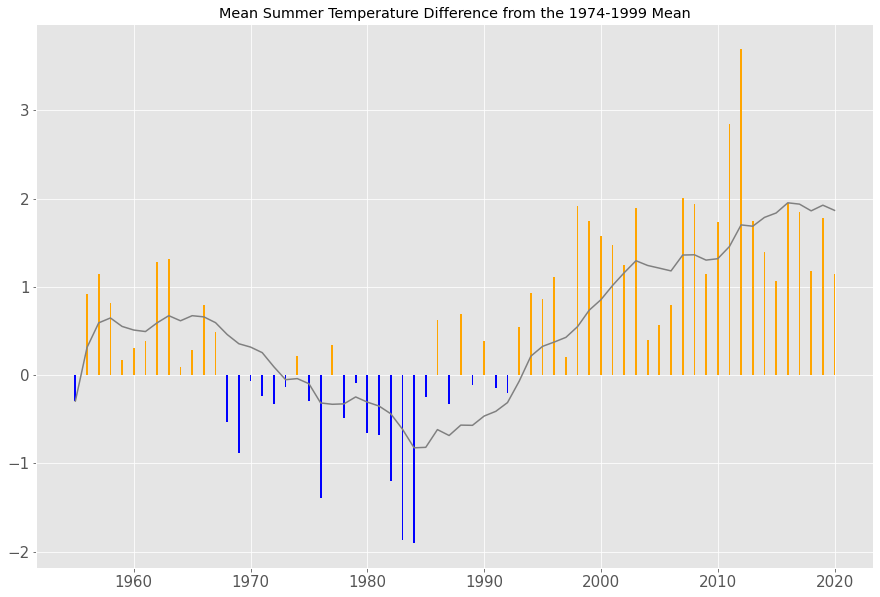

In [32]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis='both', which='major', labelsize=15)
clrs = ['blue' if (dev < 0) else 'orange' for dev in summer_devs.dev ]
ax.bar(width=0.15, x="year", height="dev", align='center', data=summer_devs, color=clrs, edgecolor='none')
ax.plot("year", "rolling_dev", data=summer_devs, color="grey")
plt.title("Mean Summer Temperature Difference from the 1974-1999 Mean")
plt.show()

### Conclusions
We can easily notice that the 21st century summers are far warmer than of the 20th. The most surprising value is in 2012, when the average temperature was more than 3 degrees higher. What is also remarkable, is the fact that there is not a certain rhythm of temperature rise over the years. However, seeing the rolling average, we can say that there is a tendency of rising temperatures since the mid 80s.    

## Evolution of Daily Temperatures

We will create two extra columns that will help in the groupings that follow: ```YEAR``` and ```DAY```. We will use a combination of the day and month, since, if we simply use the ```dayofyear```, we will have a shift for the leap years (366 days) when we draw them.

In [33]:
data['YEAR'] = data.DATE.dt.year
data['DAY'] = data.DATE.dt.strftime("%d%m")
data.head(100)

STATION       DATE   PRCP  SNWD       TAVG       TMAX       TMIN  \
0   GR000016716 1955-01-01  0.000   NaN  14.166667  18.333333  10.000000   
1   GR000016716 1955-01-02  2.032   NaN  10.833333  14.444444   7.222222   
2   GR000016716 1955-01-03  0.000   NaN  12.500000  15.555556   9.444444   
3   GR000016716 1955-01-04  0.000   NaN  13.055556  18.888889   7.222222   
4   GR000016716 1955-01-05  0.000   NaN  13.055556  17.777778   8.333333   
..          ...        ...    ...   ...        ...        ...        ...   
95  GR000016716 1955-04-06  0.000   NaN  11.944444  17.222222   6.666667   
96  GR000016716 1955-04-07  0.000   NaN  10.833333  15.000000   6.666667   
97  GR000016716 1955-04-08  0.000   NaN  10.833333  15.000000   6.666667   
98  GR000016716 1955-04-09  0.000   NaN  12.222222  17.777778   6.666667   
99  GR000016716 1955-04-10  0.000   NaN  16.388889  20.555556  12.222222   

    YEAR   DAY  
0   1955  0101  
1   1955  0201  
2   1955  0301  
3   1955  0401  
4   1955  0501  
..   ...   ...  
95  1955  0604  
96  1955  0704  
97  1955  0804  
98  1955  0904  
99  1955  1004  

[100 rows x 9 columns]

We will also create ```30day_rolling_avg``` column to smooth the daily temperatures using a 30 days rolling average. 

In [34]:
data['30day_rolling_avg'] = data.TAVG.rolling(30, min_periods=1).mean()
data.head()

STATION       DATE   PRCP  SNWD       TAVG       TMAX       TMIN  YEAR  \
0  GR000016716 1955-01-01  0.000   NaN  14.166667  18.333333  10.000000  1955   
1  GR000016716 1955-01-02  2.032   NaN  10.833333  14.444444   7.222222  1955   
2  GR000016716 1955-01-03  0.000   NaN  12.500000  15.555556   9.444444  1955   
3  GR000016716 1955-01-04  0.000   NaN  13.055556  18.888889   7.222222  1955   
4  GR000016716 1955-01-05  0.000   NaN  13.055556  17.777778   8.333333  1955   

    DAY  30day_rolling_avg  
0  0101          14.166667  
1  0201          12.500000  
2  0301          12.500000  
3  0401          12.638889  
4  0501          12.722222

Then, for the baseline (1974-1999) we will group by day and for each day we will calculate the average temperature.

In [35]:
avgs_for_1974_1999 = pd.DataFrame()
avgs_for_1974_1999['avg'] = data[(data.YEAR >= 1974) & (data.YEAR <= 1999)].groupby("DAY", sort=False).mean().TAVG
avgs_for_1974_1999

avg
DAY            
0101  10.363248
0201  10.705128
0301  10.213675
0401   9.594017
0501   9.957265
...         ...
2812  10.213675
2912  10.790598
3012  11.346154
3112  10.982906
2902   9.259259

[366 rows x 1 columns]

As we notice in the previous output, 29/02 is at the bottom of the DataFrame. That happens because the first year is not leap. So, we will move it to the right position (https://stackoverflow.com/a/63736275). Also, we do not want the ```DAY``` sorted, because we will lose the order of the days.

In [36]:
avgs_for_1974_1999.reset_index(inplace=True)
avgs_for_1974_1999.loc[58.5] = avgs_for_1974_1999.iloc[365]
avgs_for_1974_1999.drop(index=365, inplace=True)
avgs_for_1974_1999 = avgs_for_1974_1999.sort_index().reset_index(drop=True)
avgs_for_1974_1999.head()

DAY        avg
0  0101  10.363248
1  0201  10.705128
2  0301  10.213675
3  0401   9.594017
4  0501   9.957265

And finally we will create a rolling average column.

In [37]:
avgs_for_1974_1999['rolled_avg'] = avgs_for_1974_1999.avg.rolling(30, min_periods=1).mean()
avgs_for_1974_1999

DAY        avg  rolled_avg
0    0101  10.363248   10.363248
1    0201  10.705128   10.534188
2    0301  10.213675   10.427350
3    0401   9.594017   10.219017
4    0501   9.957265   10.166667
..    ...        ...         ...
361  2712   9.807692   11.620370
362  2812  10.213675   11.528490
363  2912  10.790598   11.450855
364  3012  11.346154   11.410256
365  3112  10.982906   11.366097

[366 rows x 3 columns]

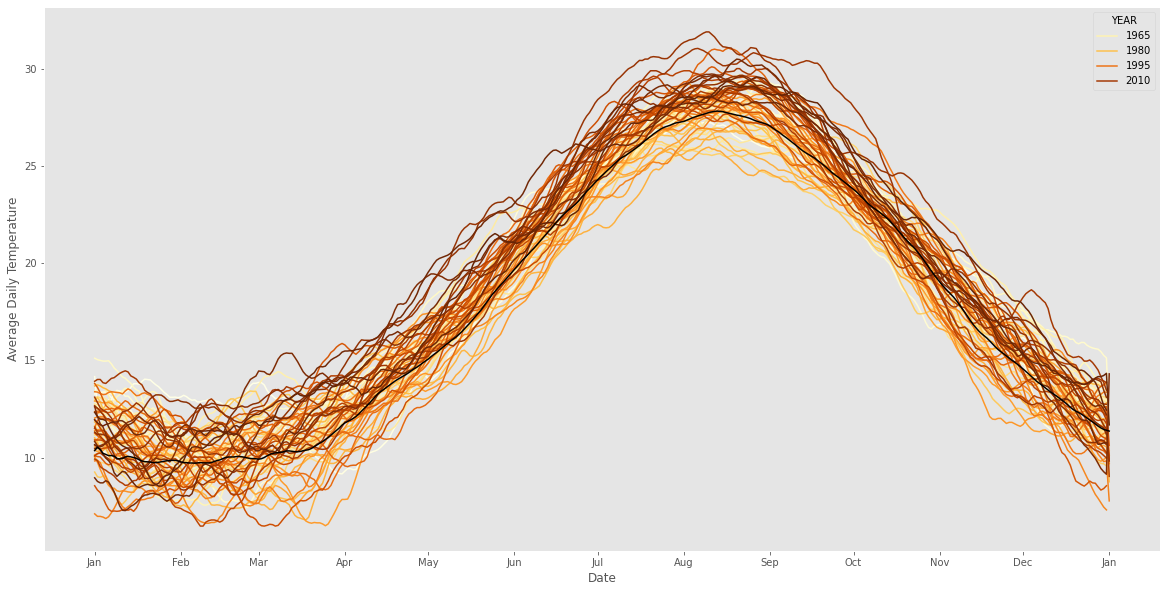

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(False)
# Setting monthly ticks https://stackoverflow.com/a/46556504
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.style.use('ggplot')
ax.set_ylabel("Average Daily Temperature")
ax.set_xlabel("Date")
ax = sns.lineplot(x="DAY", y="30day_rolling_avg", data=data, hue="YEAR", palette="YlOrBr")
ax.plot("rolled_avg", data=avgs_for_1974_1999, color="black")
plt.show()

### Conclusions
We notice that darker hues are on the top, thus temperatures have increased the later years. Generally, temperatures over the years follow a similar distribution which about each year goes upper. During the latest months of each year, average temeratures are closer to the baseline, while during the first months and summer(August and Septeber) we can notice a more significant deviation. 

## Extreme Temperature Events

We will create a dictionary with the percentage of extreme events for each year. We calculate this percentage by counting the days when the difference between this day's average and the average of the years 1974-1999 was greater than 10%. 

In [39]:
perc_of_extremes = {}
grouped_by_year = data.groupby(data.YEAR)
perc_of_extremes = dict.fromkeys(grouped_by_year.groups.keys())
for n, v in grouped_by_year:
    v.reset_index(inplace=True)
    perc_of_extremes[n] = v.loc[v.TAVG - avgs_for_1974_1999.avg > 0.1 * avgs_for_1974_1999.avg].TAVG.count() / v.shape[0]
perc_of_extremes

{1955: 0.3561643835616438,
 1956: 0.3224043715846995,
 1957: 0.32602739726027397,
 1958: 0.3780821917808219,
 1959: 0.2493150684931507,
 1960: 0.40437158469945356,
 1961: 0.3863013698630137,
 1962: 0.42191780821917807,
 1963: 0.3917808219178082,
 1964: 0.22950819672131148,
 1965: 0.3178082191780822,
 1966: 0.4438356164383562,
 1967: 0.3041095890410959,
 1968: 0.3114754098360656,
 1969: 0.25753424657534246,
 1970: 0.26575342465753427,
 1971: 0.2136986301369863,
 1972: 0.22131147540983606,
 1973: 0.2602739726027397,
 1974: 0.18082191780821918,
 1975: 0.2684931506849315,
 1976: 0.2103825136612022,
 1977: 0.32054794520547947,
 1978: 0.21095890410958903,
 1979: 0.3041095890410959,
 1980: 0.16939890710382513,
 1981: 0.25205479452054796,
 1982: 0.13972602739726028,
 1983: 0.13424657534246576,
 1984: 0.16939890710382513,
 1985: 0.24383561643835616,
 1986: 0.29041095890410956,
 1987: 0.1780821917808219,
 1988: 0.1721311475409836,
 1989: 0.24383561643835616,
 1990: 0.3287671232876712,
 1991: 0.1

We will calculate the percentage of extreme events for the years 1974-1999.

In [40]:
values = [perc_of_extremes[k] for k in range(1974, 1999 + 1)]
perc_of_extremes_1974_1999 = sum(values) / len(values)
perc_of_extremes_1974_1999

0.24992687154151333

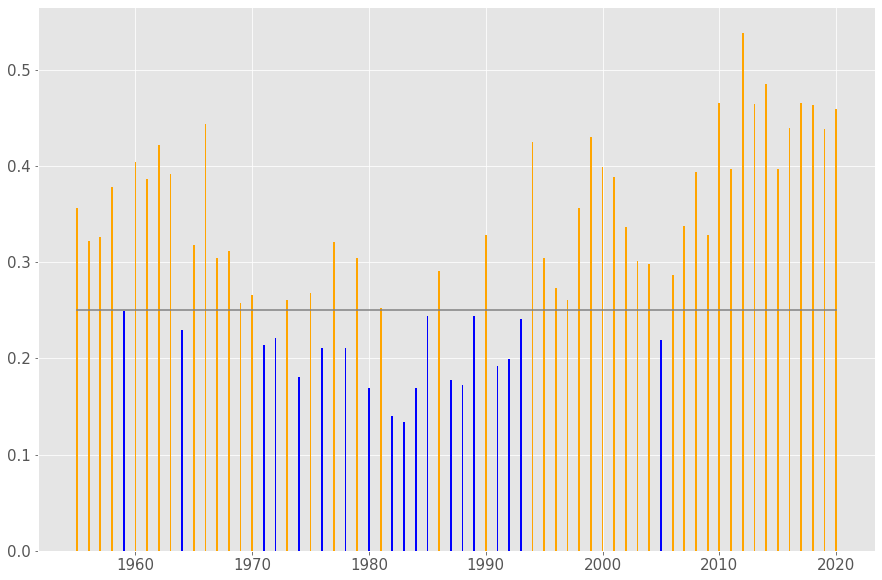

In [41]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis='both', which='major', labelsize=15)
clrs = ['blue' if (perc < perc_of_extremes_1974_1999) else 'orange' for perc in perc_of_extremes.values()]
ax.bar(width=0.15, x=list(perc_of_extremes.keys()), height=perc_of_extremes.values(), align='center', color=clrs, edgecolor='none')
ax.plot(perc_of_extremes.keys(), [perc_of_extremes_1974_1999] * (2020 - 1955 + 1), color="grey")
plt.show()

### Conclusions
After 2006 more than 30% of each year's days have extreme events and the fact that this percentage reaches almost 50% annualy could be worrying, since they can cause discomfort. This may also imply that a new baseline should be established in the future, since most temperatures will be considered extreme.

## Precipitation

We will calculate the average precipitation for the rainy days (that is why we count only the days when ```PRCP``` is > 0.2).

In [42]:
rain = pd.DataFrame({"prec": data.loc[data.PRCP > 0.2].groupby(data.YEAR).mean().PRCP})
rain.reset_index(inplace=True)
rain['perc_rolled'] = rain.prec.rolling(10, min_periods=1).mean()
rain

YEAR      prec  perc_rolled
0   1955  8.169701     8.169701
1   1956  5.628640     6.899171
2   1957  4.583545     6.127296
3   1958  5.388708     5.942649
4   1959  3.752070     5.504533
..   ...       ...          ...
61  2016  6.403474     6.036659
62  2017  6.626578     6.143447
63  2018  7.292731     6.327398
64  2019  9.831552     6.773933
65  2020  5.534526     6.574716

[66 rows x 3 columns]

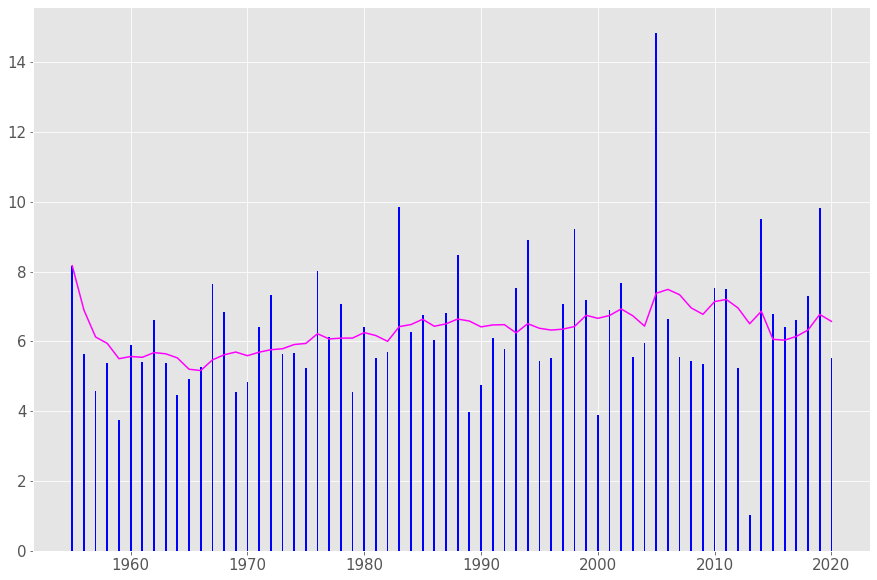

In [43]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis='both', which='major', labelsize=15)
clrs = ['blue']
ax.bar(width=0.15, x="YEAR", height="prec", data=rain, align='center', color=clrs, edgecolor='none')
ax.plot("YEAR", "perc_rolled", data=rain, color="magenta")
plt.show()

### Conclusions
We can conclude from the rolling average that precipitation slightly increases till 2005, after which there is a slight fall. Generally, we can say that precipitation increases and can be observed on the intense rainfalls that hit Athens during the latest years. 2005 appears to be the year with the most intense rainfalls. As we saw from the previous plot, during that year, the temperatures where relatively close to the baseline and they did not follow the rise that was a characteristic of the later years, so this may imply that heat and precipitation do not grow with the same rhythm. This can be seen by noticing that the years with more extreme heat events had less precipitation, compared to the others.